# FX vol trading strategy - implementation

In [142]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades
from utils.trading_strategy import gen_trading_signals
from arch import arch_model

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
fx_pairs =[
    'USDRUB',
    'USDZAR',
    'USDBRL',
    'EURUSD',
    'USDJPY',
    'GBPUSD'
]
dfs = { pair : import_data(fx_pair=pair) for pair in fx_pairs }

## Pick FX pair and set up model

In [95]:
pair = 'USDRUB'

<AxesSubplot:xlabel='Dates'>

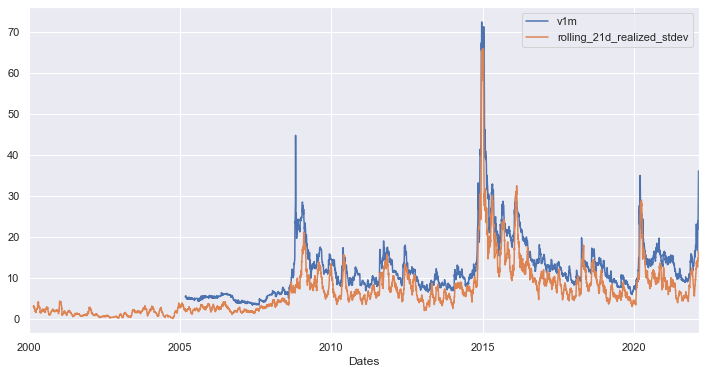

In [96]:
dfs[pair][['v1m','rolling_21d_realized_stdev']].plot(figsize=(12,6))

## Forecast volatility

In [110]:
print(model.distribution)

Standardized Student's t distribution


In [111]:
return_series = dfs[pair].dropna()['log_ret'] * 100
model = arch_model(return_series, mean='AR', vol='GARCH', p=1, q=1, dist='Studentst')

# Conditional volatility forecasting
vol_forecasts = get_rolling_vol_forecasts(return_series=return_series,
                                            model = model, 
                                            horizon=21,
                                            fitting_end_date="2021-01-01",
                                            )
df = dfs[pair].merge(vol_forecasts['h.21'], left_index=True, right_index=True)
df.rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
df['cond_forecast_to_implied'] = df['cond_vol_forecast'] / df['v1m']
df

Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 298
..........................................................................................................................................................................................................................................................................................................

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied
2021-01-01,16.3650,15.6350,14.565,74.4128,74.4000,74.4255,0.000000,10.758151,3.426832,11.816320,0.722048
2021-01-04,16.3600,15.5050,14.400,74.3254,74.3127,74.3381,-0.001175,10.448617,3.417405,11.035378,0.674534
2021-01-05,16.5800,15.5850,14.525,74.0237,74.0115,74.0359,-0.004067,10.331997,3.296242,10.470244,0.631498
2021-01-06,16.0800,15.3950,14.435,73.9273,73.9202,73.9343,-0.001303,10.306710,1.907280,9.780308,0.608228
2021-01-07,16.1150,15.4425,14.465,73.9273,73.9202,73.9343,0.000000,9.941866,1.907280,9.117689,0.565789
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-16,22.3250,20.4600,19.135,75.2695,75.2480,75.2910,-0.001288,14.159713,5.712805,20.385087,0.913106
2022-02-17,25.6800,22.1175,19.895,76.3176,76.2880,76.3472,0.013829,14.457883,7.757057,21.215598,0.826153
2022-02-18,26.5125,23.1300,20.575,77.3366,77.3102,77.3629,0.013264,14.984820,6.814372,21.800656,0.822278
2022-02-21,34.2100,28.0900,22.885,79.7535,79.7120,79.7950,0.030773,16.548842,10.407067,31.495028,0.920638


## Out-of-sample forecasting accuracy

https://stats.stackexchange.com/questions/205562/evaluate-forecasting-ability-of-garch-models-with-rmse-and-mae

Although Dunis et al. use RMSE, MAE, Theil-U and CDC, here are some considerations for why it doesn't make much sense.

In [91]:
print('Out of sample forecast accuracy measures for {}'.format(pair))
# Root Mean Squared Error
rmse = np.sqrt(np.mean((df['rolling_21d_realized_stdev'] - df['cond_vol_forecast'])**2))
print(f"RMSE: {rmse:.2f}")
# Mean Absolute Error
mae = np.mean(np.abs(df['rolling_21d_realized_stdev'] - df['cond_vol_forecast']))
print(f"MAE: {mae:.2f}")
# Theil's U
theilu = rmse / (np.sqrt(np.mean(df['rolling_21d_realized_stdev']**2)) + np.sqrt(np.mean(df['cond_vol_forecast']**2)))
print(f"Theil U: {theilu:.2f}")
# CDC
indicator = np.where(
    (df['rolling_21d_realized_stdev']-df['rolling_21d_realized_stdev'].shift(1))*(df['cond_vol_forecast']-df['rolling_21d_realized_stdev'].shift(1))>0,
    1,
    0)
cdc = np.mean(indicator) * 100
print(f"CDC: {cdc:.2f}")

RMSE: 7.87
MAE: 6.70
Theil U: 0.25
CDC: 50.67


In [113]:
model_fit = model.fit();
fit_dof = model_fit.tvalues['nu']
fit_sigma = model_fit.conditional_volatility
innovations = model_fit.resid / fit_sigma
innovations_std = (innovations - np.mean(innovations)) / np.std(innovations)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 77274.19677313154
Iteration:      2,   Func. Count:     21,   Neg. LLF: 11796.046513506126
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8393.394641713694
Iteration:      4,   Func. Count:     35,   Neg. LLF: 6174.408272079734
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3891.043982933544
Iteration:      6,   Func. Count:     48,   Neg. LLF: 6466.638784057377
Iteration:      7,   Func. Count:     55,   Neg. LLF: 11464.846769015381
Iteration:      8,   Func. Count:     63,   Neg. LLF: 5351.995234581984
Iteration:      9,   Func. Count:     70,   Neg. LLF: 3896.6736837543776
Iteration:     10,   Func. Count:     77,   Neg. LLF: 3858.3160948838467
Iteration:     11,   Func. Count:     84,   Neg. LLF: 3854.2565336069006
Iteration:     12,   Func. Count:     90,   Neg. LLF: 3854.13682840408
Iteration:     13,   Func. Count:     96,   Neg. LLF: 3854.1119256289103
Iteration:     14,   Func. Count:    102,   Neg. LLF: 3854.

https://stats.stackexchange.com/questions/408301/probability-integral-transforms-not-getting-u0-1
Here is another way of evaluating using PIT, but as the first link pointed out, this method has drawdowns too...

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


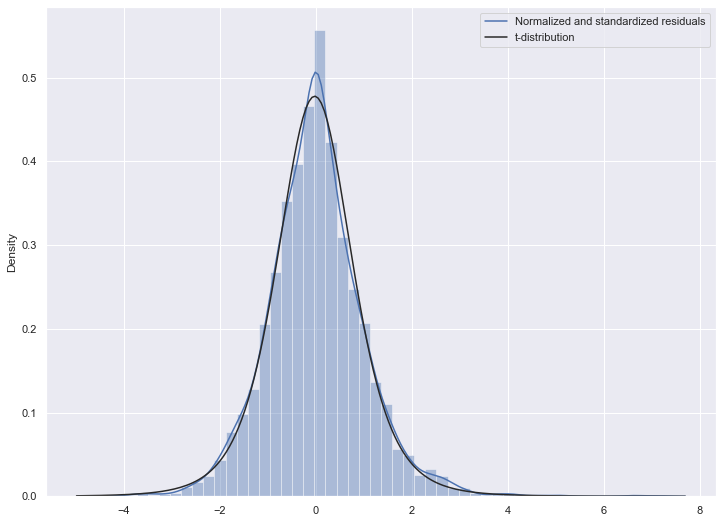

In [135]:
sns.distplot(innovations_std.dropna(), hist=True,fit=stats.t)
plt.legend(labels=['Normalized and standardized residuals','t-distribution'])
plt.show()

/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

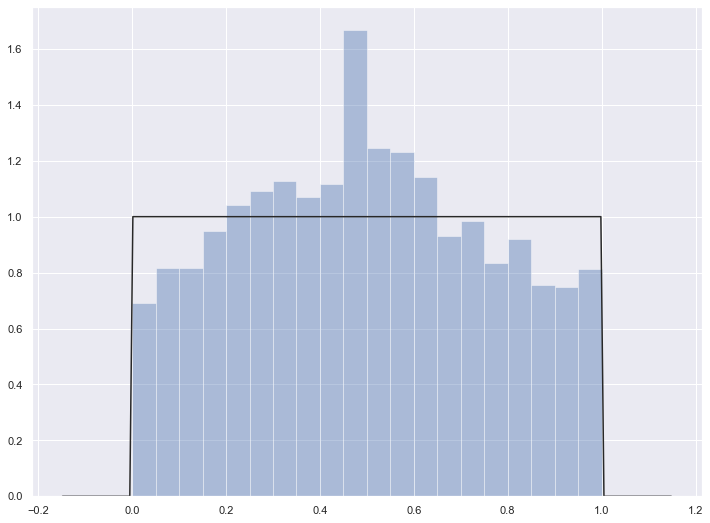

In [136]:
uni = stats.t.cdf(innovations_std, fit_dof)
uni = pd.Series(data=uni)
sns.distplot(uni.dropna(), bins=20, fit=stats.uniform, kde=False)


In [137]:
stats.kstest(innovations_std.dropna(), 'uniform').pvalue

0.0

As we can see, tails are way fatter 

## Generate trading signals

In [143]:
threshold_up = 1.1
threshold_down = 0.9

gen_trading_signals(df, days_holding_period = 21, thres_up=threshold_up,thres_down=threshold_down)
df.tail(10)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied,direction,direction_flag,returns
2022-02-09,16.8075,17.1800,17.2850,74.7125,74.6850,74.7400,-0.004018,12.716007,7.361553,12.593058,0.749252,0,nan,0.0
2022-02-10,17.6575,17.5200,17.3975,75.0180,74.9983,75.0377,0.004081,12.763916,5.252073,11.918876,0.675004,0,nan,0.0
2022-02-11,21.4275,20.4450,19.3450,77.1771,77.1437,77.2105,0.028375,13.319764,8.655417,20.557088,0.959379,0,nan,0.0
2022-02-14,23.9650,22.9350,21.3150,76.7663,76.7486,76.7840,-0.005337,13.659182,4.611398,19.392455,0.809199,0,nan,0.0
2022-02-15,21.9100,21.0350,20.4350,75.3665,75.3400,75.3930,-0.018403,14.914647,7.032302,21.908680,0.999940,0,nan,0.0
2022-02-16,22.3250,20.4600,19.1350,75.2695,75.2480,75.2910,-0.001288,14.159713,5.712805,20.385087,0.913106,0,nan,0.0
2022-02-17,25.6800,22.1175,19.8950,76.3176,76.2880,76.3472,0.013829,14.457883,7.757057,21.215598,0.826153,0,nan,0.0
2022-02-18,26.5125,23.1300,20.5750,77.3366,77.3102,77.3629,0.013264,14.984820,6.814372,21.800656,0.822278,0,nan,0.0
2022-02-21,34.2100,28.0900,22.8850,79.7535,79.7120,79.7950,0.030773,16.548842,10.407067,31.495028,0.920638,0,nan,0.0
2022-02-22,36.1150,29.0200,23.3100,80.5854,80.5718,80.5991,0.010377,16.074288,3.387708,30.485879,0.844133,0,nan,0.0


## How does the trades look?

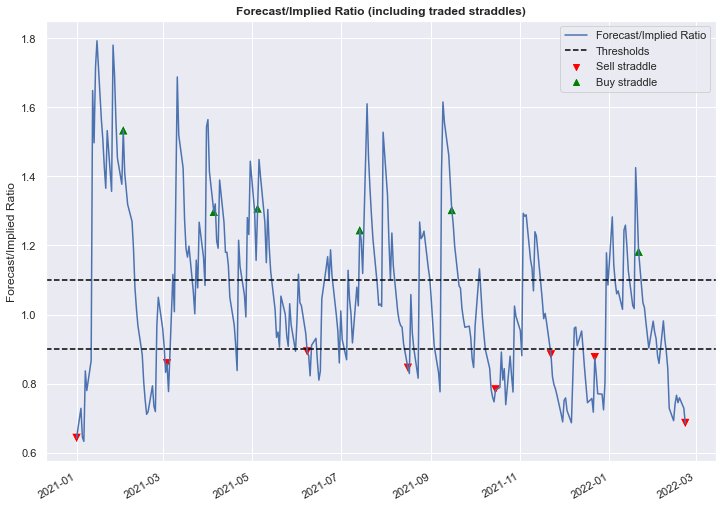

In [69]:
plot_trades(df,thres_up=threshold_up,thres_down=threshold_down)

In [70]:
df

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied,direction,direction_flag
2021-01-01,21.290,19.388,17.515,5.1985,5.1966,5.2003,0.000000,10.608245,37.0,13.676756,0.642403,-1,Sell straddle
2021-01-04,21.630,19.620,17.413,5.2717,5.2710,5.2725,0.013983,11.250801,15.0,15.759419,0.728591,0,nan
2021-01-05,22.522,19.908,17.700,5.2766,5.2761,5.2770,0.000929,10.985761,9.0,14.530992,0.645191,0,nan
2021-01-06,21.730,19.390,17.445,5.3006,5.2997,5.3015,0.004538,11.141050,18.0,13.757272,0.633100,0,nan
2021-01-07,21.823,19.895,17.500,5.4009,5.4004,5.4015,0.018746,11.840930,11.0,18.266415,0.837026,0,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-16,15.680,16.052,17.382,5.1293,5.1289,5.1297,-0.007749,9.961798,8.0,12.018819,0.766506,0,nan
2022-02-17,16.292,16.145,17.470,5.1697,5.1693,5.1701,0.007845,8.880165,8.0,12.136187,0.744917,0,nan
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,9.489284,8.0,11.633602,0.729151,0,nan


<AxesSubplot:>

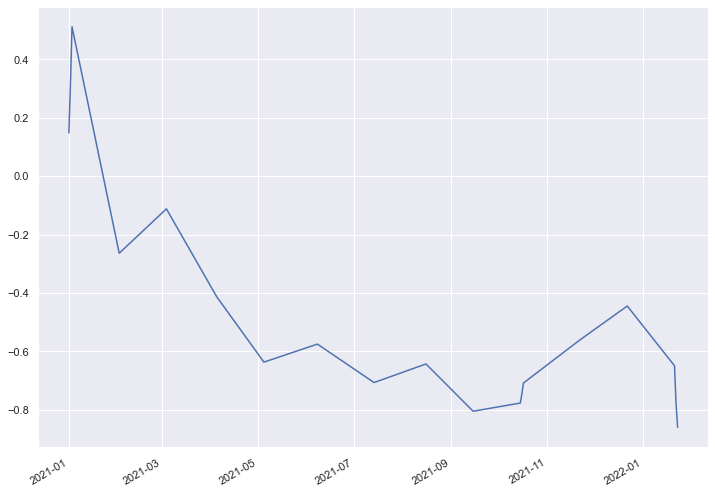

In [77]:
df_performance = df.loc[df['direction']!=0][['v1m','direction','returns']]
df.loc[pd.Timestamp('2020-08-09')] = 0
df = df.sort_index().asfreq('D', method='pad')
df_performance['normalized_pnl'] = np.cumprod(1 + df_performance['returns'].values) - 1
df_performance['normalized_pnl'].plot()


In [79]:
df

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,bid_ask_spread_pips,cond_vol_forecast,cond_forecast_to_implied,direction,direction_flag,returns
2020-08-09,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-10,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-11,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-12,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
2020-08-13,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan,0.0
2022-02-19,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan,0.0
2022-02-20,15.585,16.090,17.515,5.1388,5.1385,5.1391,-0.005995,9.209715,6.0,11.832145,0.759201,0,nan,0.0
2022-02-21,15.955,16.188,17.515,5.1064,5.1060,5.1068,-0.006325,9.489284,8.0,11.633602,0.729151,0,nan,0.0


In [78]:
df_performance

,v1m,direction,returns,normalized_pnl
2021-01-01,21.290,-1,0.147346,0.147346
2021-01-02,21.290,-1,0.147346,0.316404
2021-01-03,21.290,-1,0.147346,0.510371
2021-02-02,19.485,1,-0.512738,-0.264054
2021-03-04,19.575,-1,0.206229,-0.112281
2021-04-05,19.210,1,-0.338737,-0.412985
2021-05-05,17.347,1,-0.380548,-0.636372
2021-06-08,14.970,-1,0.169534,-0.574724
2021-07-14,17.050,1,-0.309189,-0.706215
2021-08-16,17.045,-1,0.216277,-0.642676
